Scraping using Alphavantage API

In [1]:
import requests
import csv
import time
import io

# Replace with your Alpha Vantage API key
API_KEY = "YOUR_API_KEY"

# Currency pairs to fetch
currency_pairs = ["EUR/USD", "GBP/USD", "USD/JPY", "USD/CHF"]

# Base URL for Alpha Vantage API
BASE_URL = "https://www.alphavantage.co/query"

def fetch_forex_data(from_currency, to_currency):
    params = {
        "function": "FX_DAILY",
        "from_symbol": from_currency,
        "to_symbol": to_currency,
        "apikey": API_KEY,
        "outputsize": "full",
        "datatype": "csv"
    }
    
    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        
        # Ensure it's valid CSV data
        if "timestamp,open,high,low,close" in response.text:
            return response.text
        else:
            print(f"Unexpected response format for {from_currency}/{to_currency}. Check API key and limits.")
            return None
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data for {from_currency}/{to_currency}: {e}")
        return None

def save_to_file(data, file_name, symbol):
    try:
        csv_data = io.StringIO(data.strip())  # Handle string data as file
        reader = csv.reader(csv_data)
        
        with open(file_name, "w", newline='') as file:
            writer = csv.writer(file)
            
            # Read and modify header
            header = next(reader)
            header.insert(0, "symbol")  # Add symbol column
            writer.writerow(header)
            
            # Read and modify each row
            for row in reader:
                if len(row) == 5:  # Ensure valid row
                    row[-1] = row[-1].strip()  # Fix "close\n" issue
                    writer.writerow([symbol] + row)

        print(f"Data saved to {file_name}")
    except Exception as e:
        print(f"Error saving data to {file_name}: {e}")

def main():
    for pair in currency_pairs:
        from_currency, to_currency = pair.split("/")
        symbol = f"{from_currency}{to_currency}=X"  # Custom symbol format

        print(f"Fetching data for {pair}...")
        data = fetch_forex_data(from_currency, to_currency)

        if data:
            file_name = f"{from_currency}_{to_currency}_10yr.csv"
            save_to_file(data, file_name, symbol)
        
        time.sleep(12)  # Avoid hitting API rate limits

if __name__ == "__main__":
    main()


Fetching data for EUR/USD...
Data saved to EUR_USD_10yr.csv
Fetching data for GBP/USD...
Data saved to GBP_USD_10yr.csv
Fetching data for USD/JPY...
Data saved to USD_JPY_10yr.csv
Fetching data for USD/CHF...
Data saved to USD_CHF_10yr.csv


### CLeaning the data


In [2]:
import os
import csv

def clean_csv(file_name):
    """Cleans a CSV file by removing unnecessary quotes while skipping Yahoo files."""
    
    if "Yahoo" in file_name.lower():  # Skip Yahoo files
        print(f"⏭️ Skipping: {file_name}")
        return

    file_path = os.path.join(os.getcwd(), file_name)  # Get full path of file in the current directory
    cleaned_rows = []

    try:
        with open(file_path, "r", newline="", encoding="utf-8") as file:
            reader = csv.reader(file)
            header = next(reader)

            # Remove extra quotes from the header row
            header = [col.strip('"').strip() for col in header]
            cleaned_rows.append(header)

            for row in reader:
                if len(row) == len(header):  # Ensure the row has the correct number of columns
                    row = [col.strip('"').strip() for col in row]  # Remove quotes and extra spaces
                    cleaned_rows.append(row)

        # Overwrite the original file with cleaned data
        with open(file_path, "w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file)
            writer.writerows(cleaned_rows)

        print(f"Cleaned: {file_name}")

    except Exception as e:
        print(f"❌ Error processing {file_name}: {e}")

# Automatically clean all CSV files in the current directory (except Yahoo files)
for file in os.listdir():
    if file.endswith(".csv"):  # Process only CSV files
        clean_csv(file)


Cleaned: EUR_USD_10yr.csv
Cleaned: EUR_USD_Yahoo.csv
Cleaned: forex_risk_management.csv
Cleaned: GBP_USD_10yr.csv
Cleaned: GBP_USD_Yahoo.csv
Cleaned: USD_CHF_10yr.csv
Cleaned: USD_CHF_Yahoo.csv
Cleaned: USD_JPY_10yr.csv
Cleaned: USD_JPY_Yahoo.csv


Scraping using YahooQuery API

In [3]:
from yahooquery import Ticker
import pandas as pd

# Define the ticker symbol for EUR/USD
ticker = 'EURUSD=X'

# Create a Ticker object with retry and timeout settings
forex_ticker = Ticker(ticker, retry=3, timeout=10)

# Fetch historical market data for the last 10 years with daily intervals
try:
    data = forex_ticker.history(period='10y', interval='1d')

    # Ensure data is not empty
    if not data.empty:
        # Reset index for better readability
        data.reset_index(inplace=True)

        # Save data to CSV file
        csv_path = r"EUR_USD_Yahoo.csv"
        data.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

        # Display basic insights
        print("\nBasic Statistics:")
        print(data.describe())

        # Get the latest close price
        latest_price = data['close'].iloc[-1]
        print(f"\nLatest Close Price: {latest_price}")

    else:
        print("No data available for EUR/USD.")

except Exception as e:
    print(f"Error fetching data: {e}")

c:\Users\acer\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
c:\Users\acer\anaconda3\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Data saved to EUR_USD_Yahoo.csv

Basic Statistics:
              open         high          low        close  volume     adjclose
count  2607.000000  2607.000000  2607.000000  2607.000000  2607.0  2607.000000
mean      0.897263     0.900137     0.894417     0.897262     0.0     0.897262
std       0.042687     0.043158     0.042222     0.042705     0.0     0.042705
min       0.799233     0.803219     0.796533     0.799412     0.0     0.799412
25%       0.866893     0.869119     0.863972     0.866927     0.0     0.866927
50%       0.898674     0.901957     0.895937     0.898715     0.0     0.898715
75%       0.923877     0.926518     0.920925     0.923877     0.0     0.923877
max       1.095770     1.107175     1.095770     1.105950     0.0     1.105950

Latest Close Price: 1.1059499979019165


In [4]:
from yahooquery import Ticker
import pandas as pd

# Define the ticker symbol for EUR/USD
ticker = 'GBPUSD=X'

# Create a Ticker object with retry and timeout settings
forex_ticker = Ticker(ticker, retry=3, timeout=10)

# Fetch historical market data for the last 10 years with daily intervals
try:
    data = forex_ticker.history(period='10y', interval='1d')

    # Ensure data is not empty
    if not data.empty:
        # Reset index for better readability
        data.reset_index(inplace=True)

        # Save data to CSV file
        csv_path = r"GBP_USD_Yahoo.csv"
        data.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

        # Display basic insights
        print("\nBasic Statistics:")
        print(data.describe())

        # Get the latest close price
        latest_price = data['close'].iloc[-1]
        print(f"\nLatest Close Price: {latest_price}")

    else:
        print("No data available for EUR/USD.")

except Exception as e:
    print(f"Error fetching data: {e}")

Data saved to GBP_USD_Yahoo.csv

Basic Statistics:
              open         high          low        close  volume     adjclose
count  2607.000000  2607.000000  2607.000000  2607.000000  2607.0  2607.000000
mean      0.764433     0.767804     0.761658     0.764767     0.0     0.764767
std       0.052472     0.051083     0.052002     0.050370     0.0     0.050370
min       0.002026     0.631493     0.002009     0.629921     0.0     0.629921
25%       0.738258     0.741087     0.736041     0.738364     0.0     0.738364
50%       0.771623     0.773880     0.768775     0.771736     0.0     0.771736
75%       0.796943     0.799843     0.794291     0.797006     0.0     0.797006
max       1.277205     1.285727     1.276927     1.283252     0.0     1.283252

Latest Close Price: 1.283252239227295


c:\Users\acer\anaconda3\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


In [5]:
from yahooquery import Ticker
import pandas as pd

# Define the ticker symbol for EUR/USD
ticker = 'USDCHF=X'

# Create a Ticker object with retry and timeout settings
forex_ticker = Ticker(ticker, retry=3, timeout=10)

# Fetch historical market data for the last 10 years with daily intervals
try:
    data = forex_ticker.history(period='10y', interval='1d')

    # Ensure data is not empty
    if not data.empty:
        # Reset index for better readability
        data.reset_index(inplace=True)

        # Save data to CSV file
        csv_path = r"USD_CHF_Yahoo.csv"
        data.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

        # Display basic insights
        print("\nBasic Statistics:")
        print(data.describe())

        # Get the latest close price
        latest_price = data['close'].iloc[-1]
        print(f"\nLatest Close Price: {latest_price}")

    else:
        print("No data available for EUR/USD.")

except Exception as e:
    print(f"Error fetching data: {e}")

Data saved to USD_CHF_Yahoo.csv

Basic Statistics:
              open         high          low        close  volume     adjclose
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.0  2606.000000
mean      0.947439     0.950461     0.944385     0.947412     0.0     0.947412
std       0.044160     0.044238     0.044142     0.044149     0.0     0.044149
min       0.840759     0.841900     0.833000     0.840500     0.0     0.840500
25%       0.912000     0.914663     0.909163     0.911971     0.0     0.911971
50%       0.958045     0.961520     0.954260     0.958050     0.0     0.958050
75%       0.986422     0.989473     0.983700     0.986325     0.0     0.986325
max       1.030200     1.033240     1.027860     1.030200     0.0     1.030200

Latest Close Price: 0.8424599766731262


c:\Users\acer\anaconda3\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


In [6]:
from yahooquery import Ticker
import pandas as pd

# Define the ticker symbol for EUR/USD
ticker = 'USDJPY=X'

# Create a Ticker object with retry and timeout settings
forex_ticker = Ticker(ticker, retry=3, timeout=10)

# Fetch historical market data for the last 10 years with daily intervals
try:
    data = forex_ticker.history(period='10y', interval='1d')

    # Ensure data is not empty
    if not data.empty:
        # Reset index for better readability
        data.reset_index(inplace=True)

        # Save data to CSV file
        csv_path = r"USD_JPY_Yahoo.csv"
        data.to_csv(csv_path, index=False)
        print(f"Data saved to {csv_path}")

        # Display basic insights
        print("\nBasic Statistics:")
        print(data.describe())

        # Get the latest close price
        latest_price = data['close'].iloc[-1]
        print(f"\nLatest Close Price: {latest_price}")

    else:
        print("No data available for EUR/USD.")

except Exception as e:
    print(f"Error fetching data: {e}")

Data saved to USD_JPY_Yahoo.csv

Basic Statistics:
              open         high          low        close  volume     adjclose
count  2606.000000  2606.000000  2606.000000  2606.000000  2606.0  2606.000000
mean    121.031470   121.438518   120.594813   121.029890     0.0   121.029890
std      16.538289    16.648221    16.409799    16.538487     0.0    16.538487
min      99.892998   100.379997    99.572998    99.905998     0.0    99.905998
25%     109.016251   109.363998   108.699749   109.025251     0.0   109.025251
50%     112.869499   113.280502   112.605503   112.876499     0.0   112.876499
75%     134.213505   134.938255   133.657001   134.213505     0.0   134.213505
max     161.621002   161.942001   161.300003   161.621002     0.0   161.621002

Latest Close Price: 145.26499938964844


c:\Users\acer\anaconda3\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


Arbitrage opportunity


Detecting arbitrage for EUR_USD...



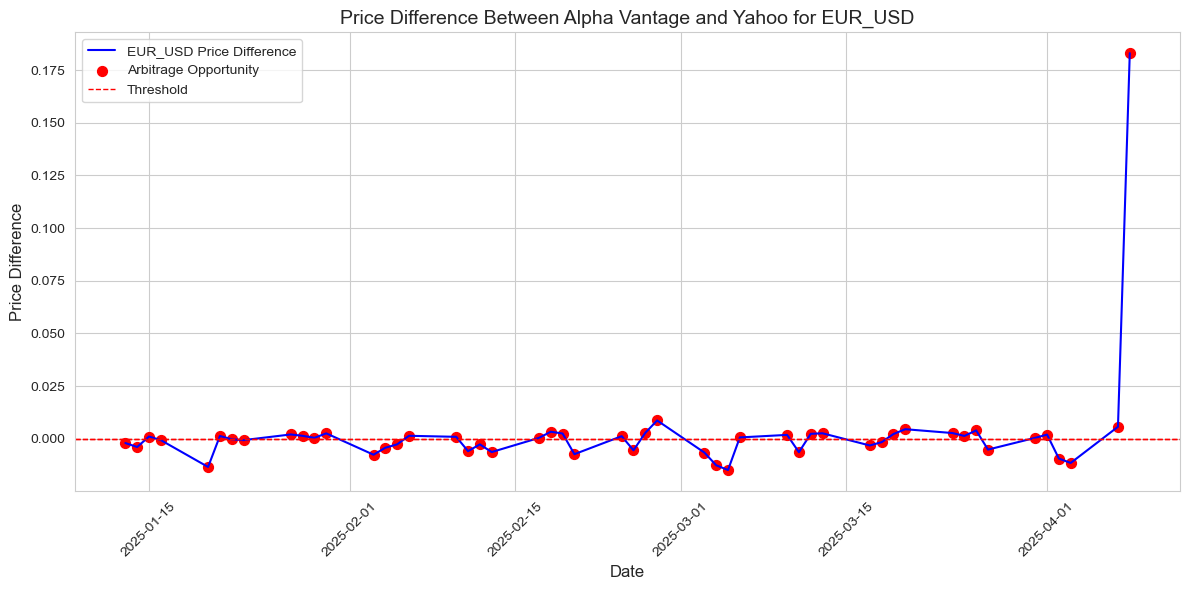


Detecting arbitrage for GBP_USD...



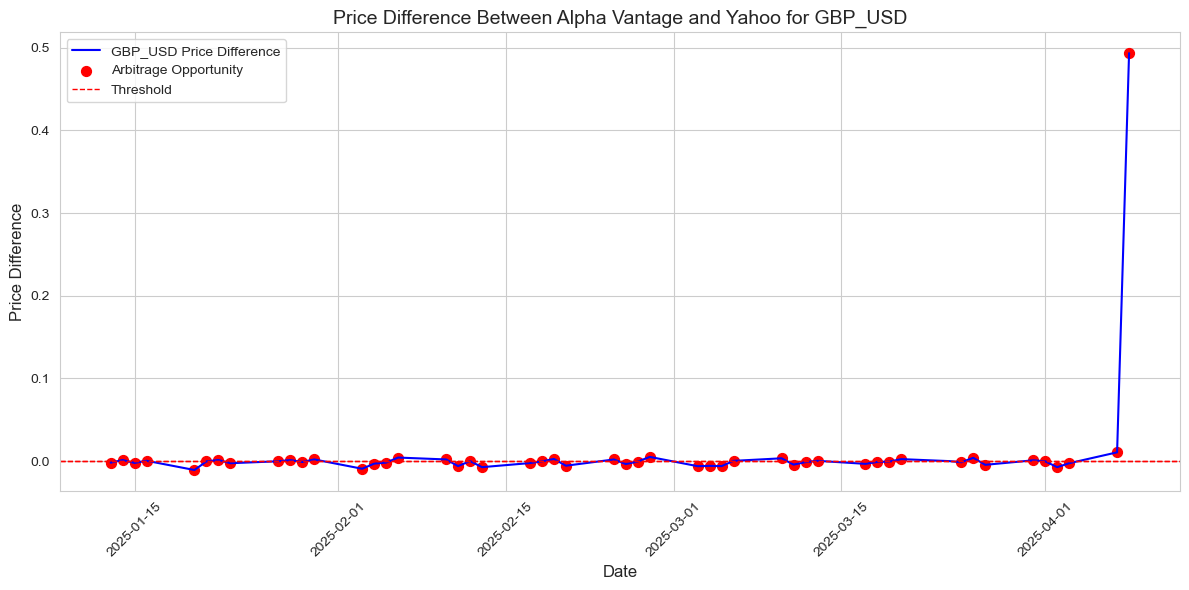


Detecting arbitrage for USD_CHF...



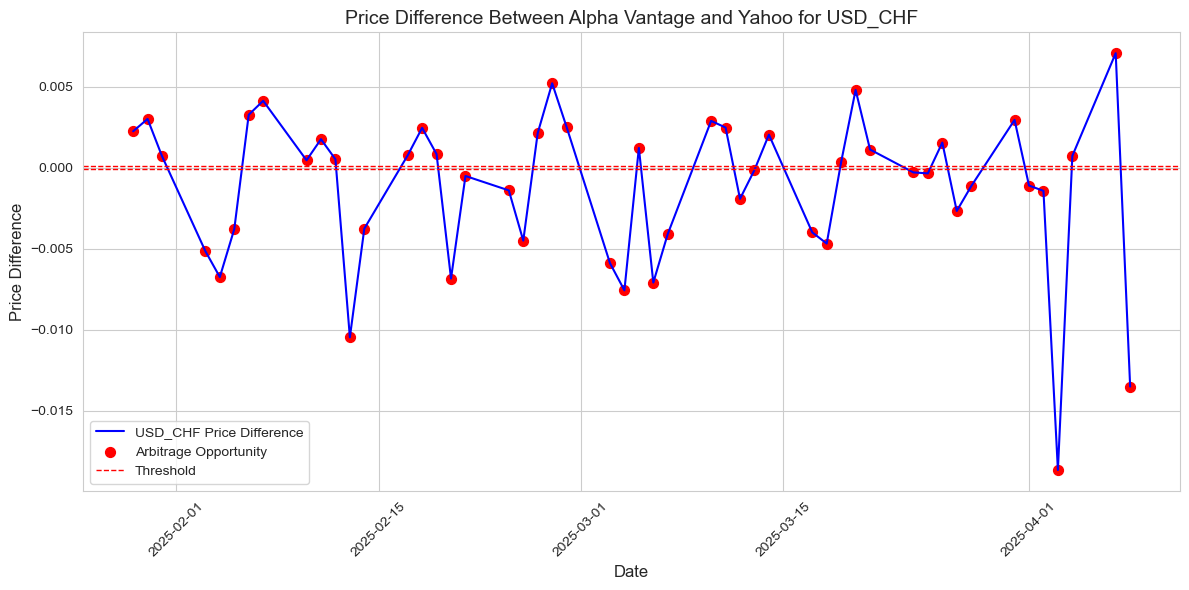


Detecting arbitrage for USD_JPY...



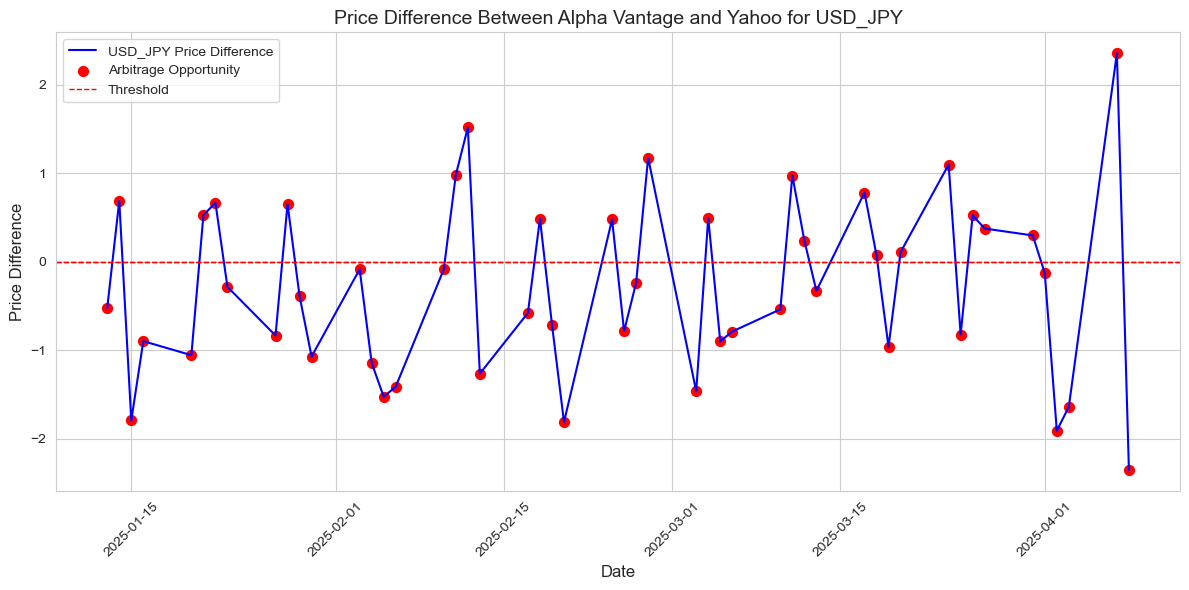

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Apply seaborn style for better visualization
sns.set_style("whitegrid")

# Function to detect arbitrage (only for last 50 days)
def detect_arbitrage(alpha_path, yahoo_path, threshold=0.0001):
    # Load data
    alpha_data = pd.read_csv(alpha_path)
    yahoo_data = pd.read_csv(yahoo_path)

    # Ensure 'date' columns exist and match formats
    alpha_data.rename(columns={'timestamp': 'date'}, inplace=True)
    alpha_data['date'] = pd.to_datetime(alpha_data['date'], errors='coerce')
    yahoo_data['date'] = pd.to_datetime(yahoo_data['date'], errors='coerce')

    # Drop invalid dates
    alpha_data.dropna(subset=['date'], inplace=True)
    yahoo_data.dropna(subset=['date'], inplace=True)

    # Merge on 'date'
    merged_data = pd.merge(
        alpha_data[['date', 'close']],
        yahoo_data[['date', 'close']],
        on='date',
        suffixes=('_alpha', '_yahoo')
    )

    # Sort by date
    merged_data.sort_values(by='date', inplace=True)

    # Keep only last 50 days
    merged_data = merged_data.tail(50)

    # Calculate price difference
    merged_data['price_diff'] = merged_data['close_alpha'] - merged_data['close_yahoo']

    # Flag arbitrage opportunities
    merged_data['arbitrage'] = merged_data['price_diff'].apply(lambda x: abs(x) > threshold)

    return merged_data

# Define file paths
currency_pairs = {
    "EUR_USD": {"alpha": "EUR_USD_10yr.csv", "yahoo": "EUR_USD_Yahoo.csv"},
    "GBP_USD": {"alpha": "GBP_USD_10yr.csv", "yahoo": "GBP_USD_Yahoo.csv"},
    "USD_CHF": {"alpha": "USD_CHF_10yr.csv", "yahoo": "USD_CHF_Yahoo.csv"},
    "USD_JPY": {"alpha": "USD_JPY_10yr.csv", "yahoo": "USD_JPY_Yahoo.csv"}
}

# Loop over each currency pair and detect arbitrage
for pair, paths in currency_pairs.items():
    print(f"\nDetecting arbitrage for {pair}...\n")
    merged_data = detect_arbitrage(paths['alpha'], paths['yahoo'])

    # Plot the price difference
    plt.figure(figsize=(12, 6))
    plt.plot(merged_data['date'], merged_data['price_diff'], label=f'{pair} Price Difference', color='blue', linewidth=1.5)
    
    # Highlight arbitrage points
    arbitrage_points = merged_data[merged_data['arbitrage']]
    plt.scatter(arbitrage_points['date'], arbitrage_points['price_diff'], color='red', label="Arbitrage Opportunity", marker='o', s=50)

    # Threshold lines
    plt.axhline(y=0.0001, color='r', linestyle='--', linewidth=1, label='Threshold')
    plt.axhline(y=-0.0001, color='r', linestyle='--', linewidth=1)

    # Formatting
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Price Difference', fontsize=12)
    plt.title(f'Price Difference Between Alpha Vantage and Yahoo for {pair}', fontsize=14)
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis for better visibility
    plt.tight_layout()
    plt.show()

Risk and return

c:\Users\acer\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


  Currency Pair  Mean Return  Volatility  Sharpe Ratio  Sortino Ratio  \
0       EUR/USD     0.008604    0.624508      0.013777       0.026189   
1       GBP/USD     0.031926    1.363957      0.023407       0.085113   
2       USD/CHF    -0.006566    0.631602     -0.010396      -0.012740   
3       USD/JPY     0.008887    0.560094      0.015868       0.021549   

   Max Drawdown  
0    -16.946141  
1    -20.121834  
2    -45.471042  
3    -20.475368  


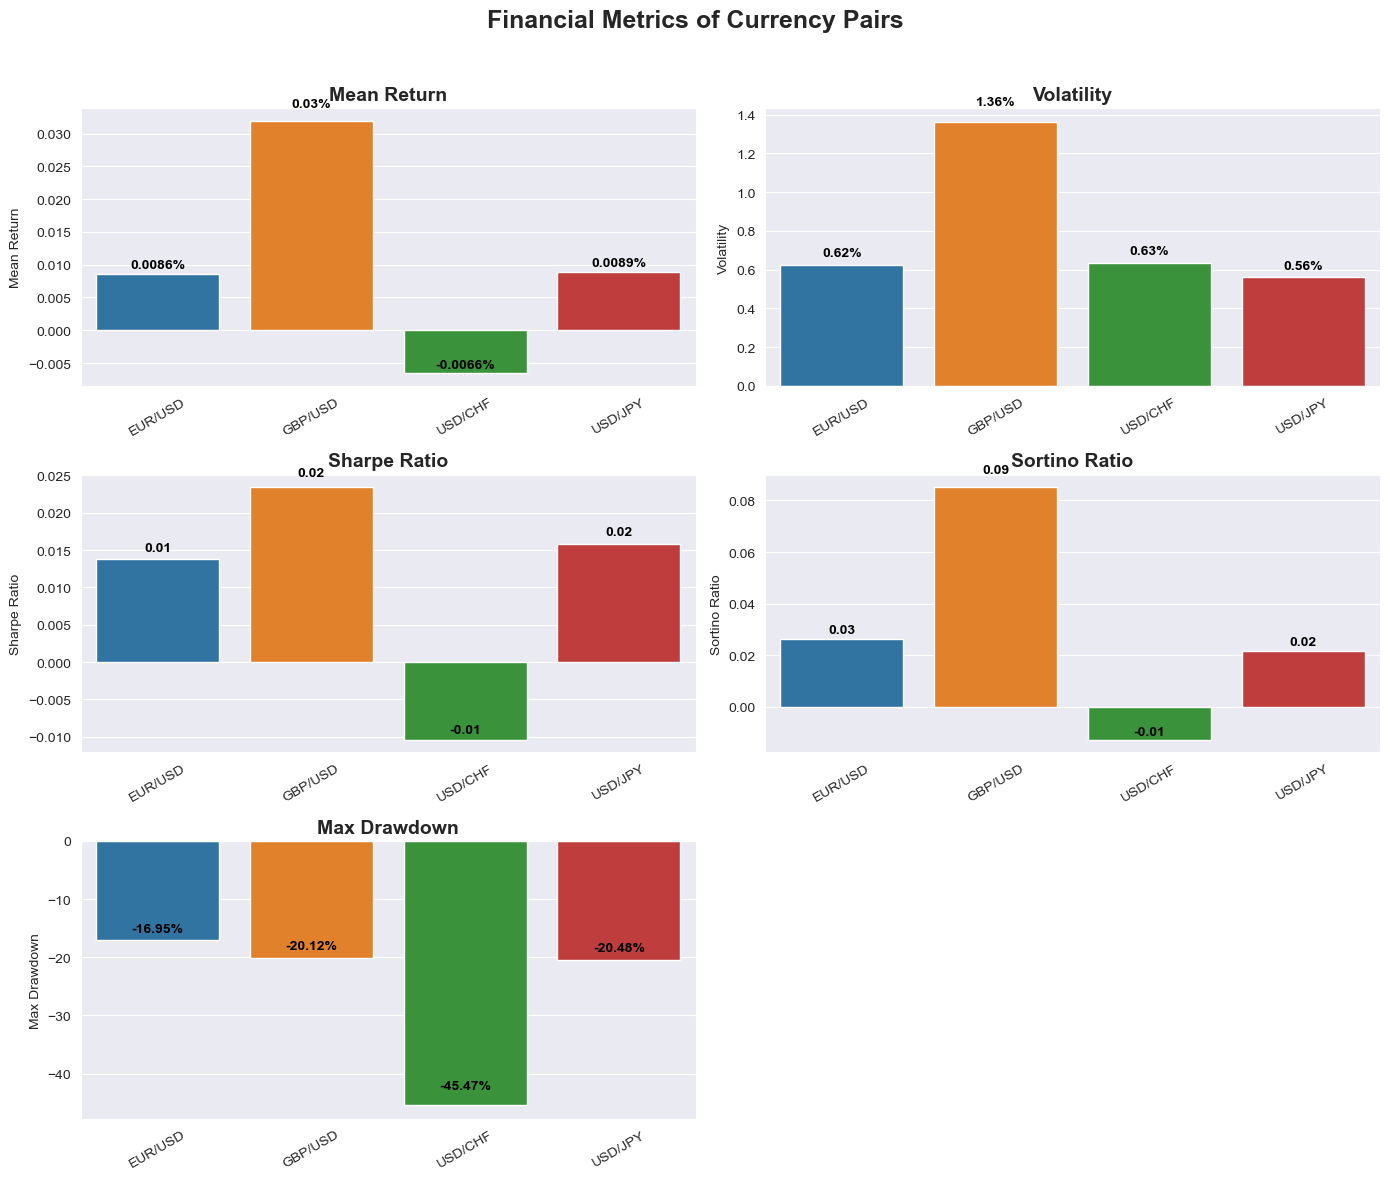

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
# Apply seaborn style
sns.set_style("darkgrid")
 
# Function to calculate financial metrics
def calculate_metrics(data):
    # Ensure sorted data
    data = data.sort_values(by='date')
 
    # Calculate daily returns
    data['daily_return'] = data['close'].pct_change().fillna(0)
 
    # Calculate Mean Return
    mean_return = data['daily_return'].mean()
 
    # Calculate Volatility (Standard Deviation)
    volatility = data['daily_return'].std()
 
    # Calculate Sharpe Ratio (assuming risk-free rate of 0)
    sharpe_ratio = mean_return / volatility if volatility != 0 else np.nan
 
    # Calculate Sortino Ratio (assuming a risk-free rate of 0)
    downside_returns = data['daily_return'][data['daily_return'] < 0]
    downside_std = downside_returns.std()
    sortino_ratio = mean_return / downside_std if downside_std != 0 else np.nan
 
    # Calculate Max Drawdown
    data['cumulative_returns'] = (1 + data['daily_return']).cumprod()
    data['cumulative_max'] = data['cumulative_returns'].cummax()
    data['drawdown'] = (data['cumulative_returns'] / data['cumulative_max']) - 1
    max_drawdown = data['drawdown'].min()
 
    return mean_return, volatility, sharpe_ratio, sortino_ratio, max_drawdown
 
# List of file paths for the data
files = {
    'EUR/USD': 'EUR_USD_10yr.csv',
    'GBP/USD': 'GBP_USD_10yr.csv',
    'USD/CHF': 'USD_CHF_10yr.csv',
    'USD/JPY': 'USD_JPY_10yr.csv'
}
 
# Empty list to store results
results = []
 
# Loop through each file and calculate metrics
for pair, file in files.items():
    data = pd.read_csv(file)
 
    # Ensure correct column names
    if 'timestamp' in data.columns:
        data.rename(columns={'timestamp': 'date'}, inplace=True)
 
    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], errors='coerce')
    data.dropna(subset=['date'], inplace=True)
 
    # Calculate metrics for this pair
    mean_return, volatility, sharpe_ratio, sortino_ratio, max_drawdown = calculate_metrics(data)
   
    # Append the results for this pair
    results.append({
        'Currency Pair': pair,
        'Mean Return': mean_return * 100,  # Convert to percentage
        'Volatility': volatility * 100,  # Convert to percentage
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown * 100  # Convert to percentage
    })
 
# Convert the results to a DataFrame
metrics_df = pd.DataFrame(results)
 
# Print the results
print(metrics_df)
 
# Plot results with enhanced visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Financial Metrics of Currency Pairs", fontsize=18, fontweight="bold")
 
# Define custom color palette
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
 
# List of metrics
metrics = ['Mean Return', 'Volatility', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown']
axes = axes.flatten()  # Flatten to easily iterate
 
# Loop through each metric and create a bar plot
for i, metric in enumerate(metrics):
    ax = axes[i]
    sns.barplot(x="Currency Pair", y=metric, data=metrics_df, ax=ax, palette=colors)
   
    # Set title and remove x-label
    ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xlabel("")
   
    # Rotate x-axis labels for better visibility
    ax.tick_params(axis='x', rotation=30)
 
    # Add formatted labels above bars with better positioning
    for p in ax.patches:
        height = p.get_height()
        if not np.isnan(height):  # Avoid displaying NaN values
            # Use more decimal places for very small values
            if abs(height) < 0.01:
                if metric in ["Mean Return", "Volatility", "Max Drawdown"]:
                    fmt = "{:.4f}%"  # 4 decimal places for percentages
                else:
                    fmt = "{:.4f}"  # 4 decimal places for ratios
            else:
                if metric in ["Mean Return", "Volatility", "Max Drawdown"]:
                    fmt = "{:.2f}%"  # Show percentages
                else:
                    fmt = "{:.2f}"  # Keep Sharpe/Sortino as decimal values
                   
            ax.annotate(fmt.format(height),
                        (p.get_x() + p.get_width() / 2., height + (abs(height) * 0.05)),
                        ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
 
# Remove empty subplot
fig.delaxes(axes[-1])
 
# Adjust layout for better fitting
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Portfolio Optimization Using Mean-Variance


Mean Returns:
EUR_USD   -0.000077
GBP_USD   -0.000304
USD_CHF    0.000055
USD_JPY   -0.000090
dtype: float64

Optimized Portfolio Weights:
EUR_USD: 0.0500
GBP_USD: 0.0500
USD_CHF: 0.8500
USD_JPY: 0.0500

Optimized Portfolio Performance:
Expected Portfolio Return: 0.000023
Portfolio Volatility (Standard Deviation): 0.004117
Sharpe Ratio: 0.0056


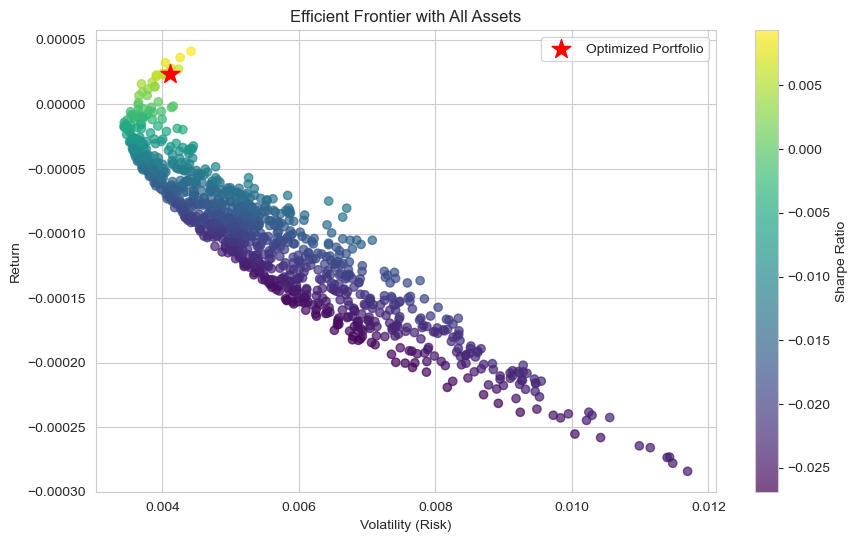

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Function to calculate log returns safely
def calculate_log_returns(data, column_name):
    data['log_return'] = np.log(data[column_name] / data[column_name].shift(1))
    return data.dropna(subset=['log_return'])

# Load and process the data
currency_pairs = {
    "EUR_USD": {"alpha": "EUR_USD_10yr.csv", "yahoo": "EUR_USD_Yahoo.csv"},
    "GBP_USD": {"alpha": "GBP_USD_10yr.csv", "yahoo": "GBP_USD_Yahoo.csv"},
    "USD_CHF": {"alpha": "USD_CHF_10yr.csv", "yahoo": "USD_CHF_Yahoo.csv"},
    "USD_JPY": {"alpha": "USD_JPY_10yr.csv", "yahoo": "USD_JPY_Yahoo.csv"}
}

log_returns = {}

for pair, paths in currency_pairs.items():
    alpha_data = pd.read_csv(paths['alpha'])
    yahoo_data = pd.read_csv(paths['yahoo'])

    alpha_data.rename(columns={'timestamp': 'date'}, inplace=True)
    alpha_data['date'] = pd.to_datetime(alpha_data['date'], errors='coerce')
    yahoo_data['date'] = pd.to_datetime(yahoo_data['date'], errors='coerce')

    alpha_data.dropna(subset=['date'], inplace=True)
    yahoo_data.dropna(subset=['date'], inplace=True)

    merged_data = pd.merge(alpha_data[['date', 'close']], yahoo_data[['date', 'close']], on='date', suffixes=('_alpha', '_yahoo'))
    log_returns[pair] = calculate_log_returns(merged_data, 'close_alpha')

# Combine log returns into a single DataFrame
returns_data = pd.DataFrame({pair: log_returns[pair]['log_return'] for pair in log_returns})

# Compute statistics
mean_returns = returns_data.mean()
cov_matrix = returns_data.cov()

# Portfolio performance metrics
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

# Objective: Minimize negative Sharpe Ratio (maximize SR)
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.0):
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    if vol == 0:
        return 1e6
    return -(ret - risk_free_rate) / vol

# Constraints
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

# Minimum 5% allocation to each asset
bounds = [(0.05, 1.0) for _ in range(len(mean_returns))]

# Initial equal weights
initial_guess = [1.0 / len(mean_returns)] * len(mean_returns)

# Optimization
optimized_result = minimize(
    negative_sharpe_ratio,
    initial_guess,
    args=(mean_returns, cov_matrix),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# Results
optimized_weights = optimized_result.x
opt_return, opt_volatility = portfolio_performance(optimized_weights, mean_returns, cov_matrix)
sharpe_ratio = (opt_return) / opt_volatility

# Print Results
print("\nMean Returns:")
print(mean_returns)

print("\nOptimized Portfolio Weights:")
for i, weight in enumerate(optimized_weights):
    print(f"{returns_data.columns[i]}: {weight:.4f}")

print("\nOptimized Portfolio Performance:")
print(f"Expected Portfolio Return: {opt_return:.6f}")
print(f"Portfolio Volatility (Standard Deviation): {opt_volatility:.6f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")

# Plot Efficient Frontier
portfolio_returns = []
portfolio_volatilities = []
num_simulations = 1000

for _ in range(num_simulations):
    weights = np.random.dirichlet(np.ones(len(mean_returns)), size=1)[0]
    ret, vol = portfolio_performance(weights, mean_returns, cov_matrix)
    portfolio_returns.append(ret)
    portfolio_volatilities.append(vol)

plt.figure(figsize=(10, 6))
plt.scatter(portfolio_volatilities, portfolio_returns, c=np.array(portfolio_returns) / np.array(portfolio_volatilities), cmap='viridis', alpha=0.7)
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Return")
plt.title("Efficient Frontier with All Assets")
plt.scatter(opt_volatility, opt_return, color='red', marker='*', s=200, label="Optimized Portfolio")
plt.legend()
plt.grid(True)
plt.show()

LSTM for Price Prediction

Processing EUR_USD...


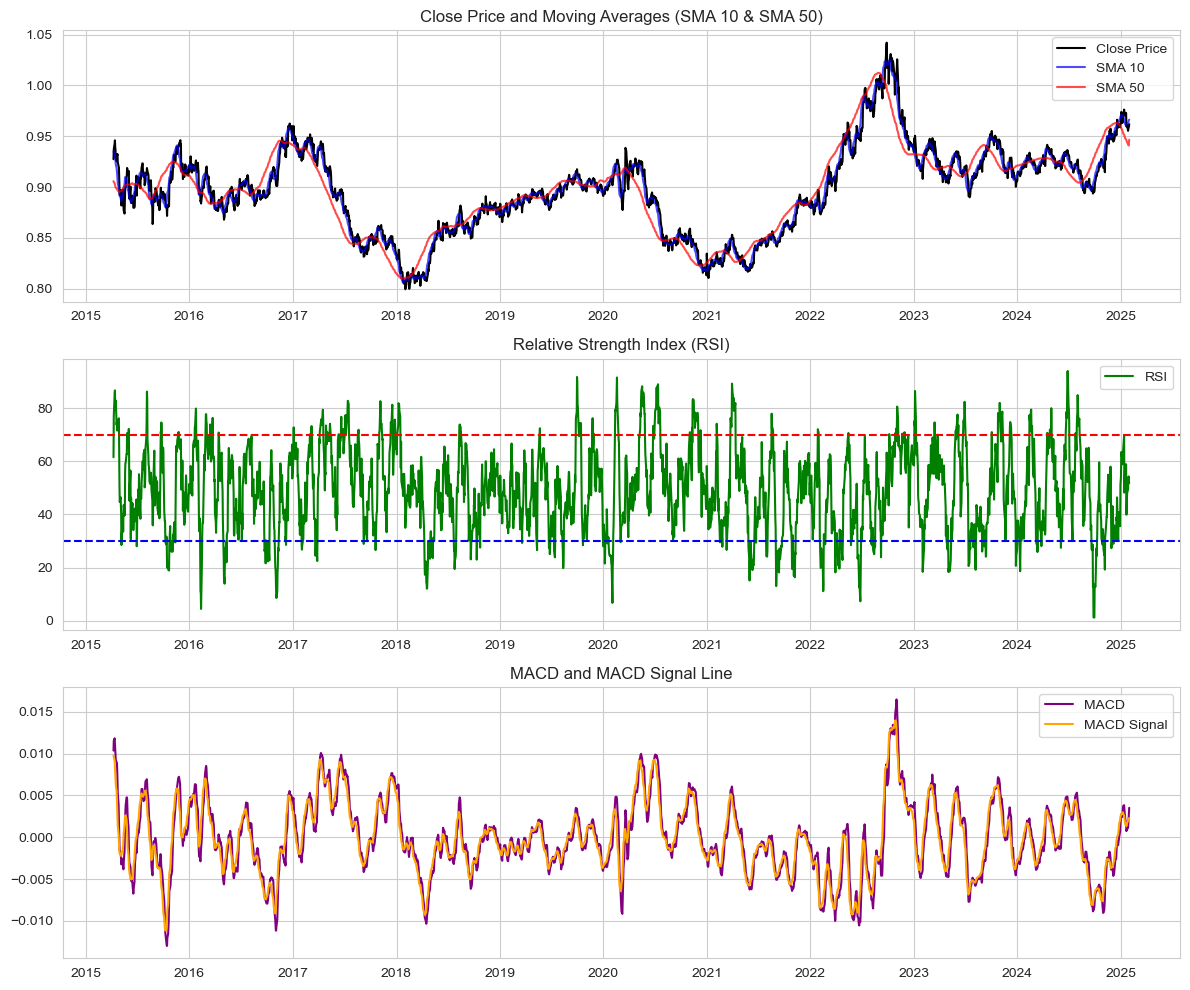

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1321
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0013
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.1164e-04
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0305e-04
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3532e-04
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0221e-04
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.5572e-05
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5306e-05
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4080e-05
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.9914e-05
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.4266e-05
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3879e-05
Epoch 13/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.7379e-05
Epoch 14/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8232e-05
Epoch 15/

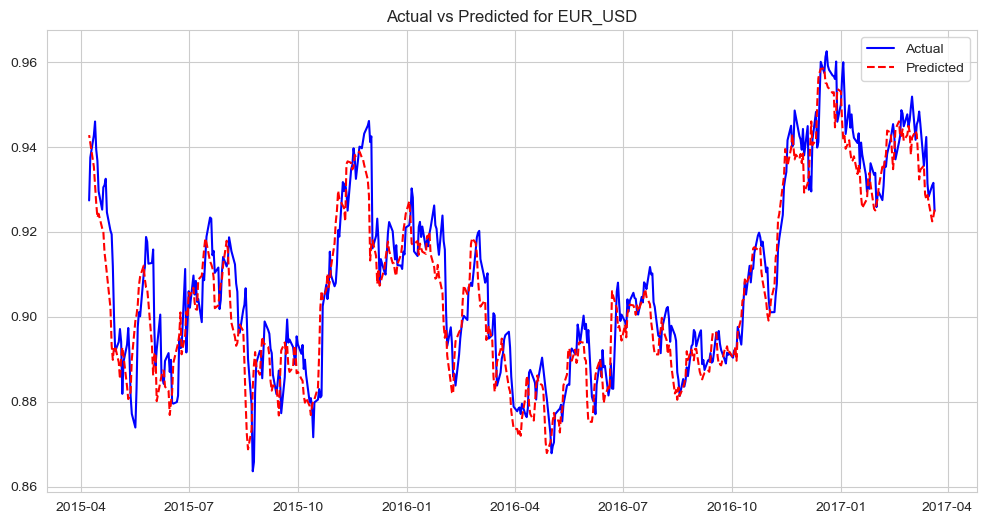

Processing GBP_USD...


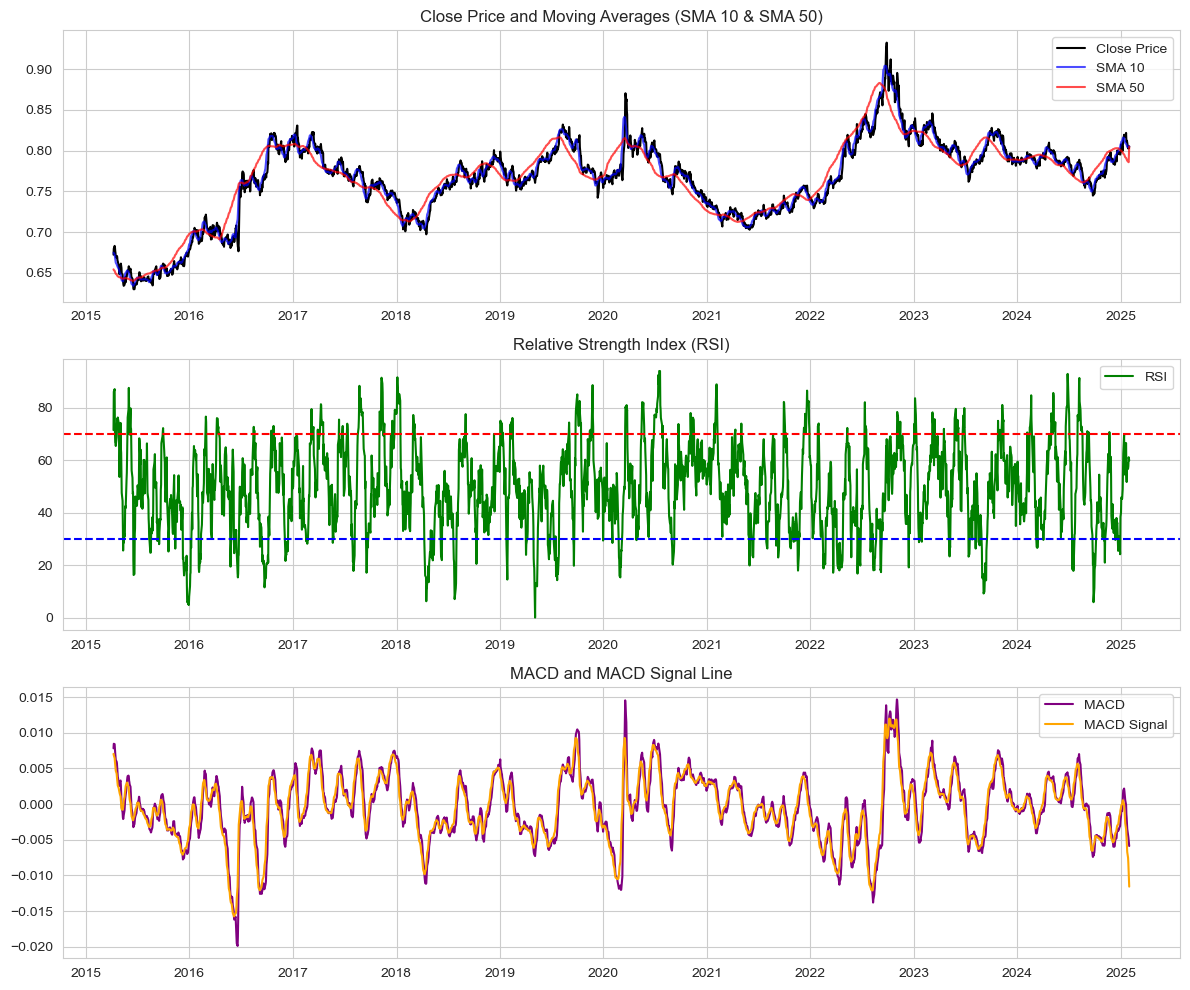

Epoch 1/50


c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0722
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7626e-04
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1647e-04
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2897e-04
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1080e-04
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0788e-04
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2319e-04
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0394e-04
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0312e-04
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0687e-04
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3338e-05
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3395e-05
Epoch 13/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.6244e-05
Epoch 14/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0289e-04
Epoch 15/50
128/

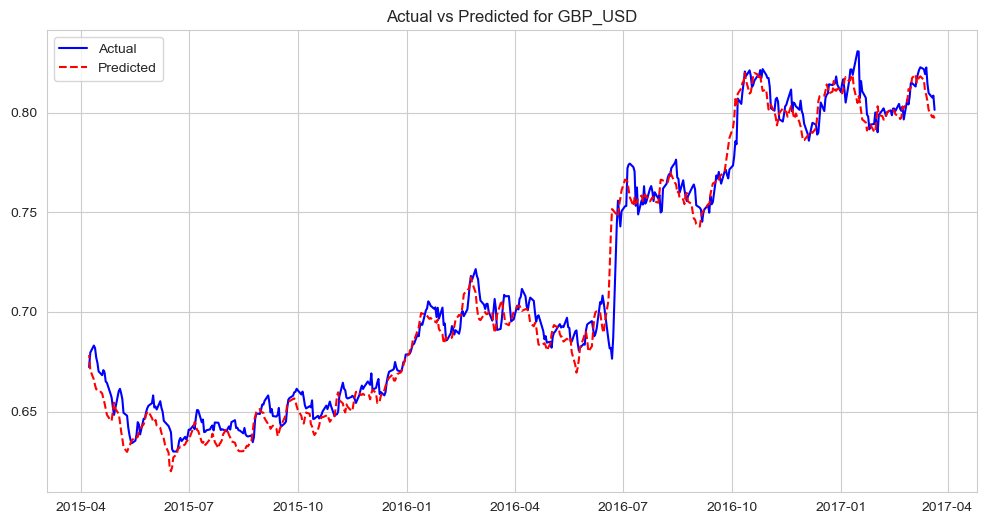

Processing USD_JPY...


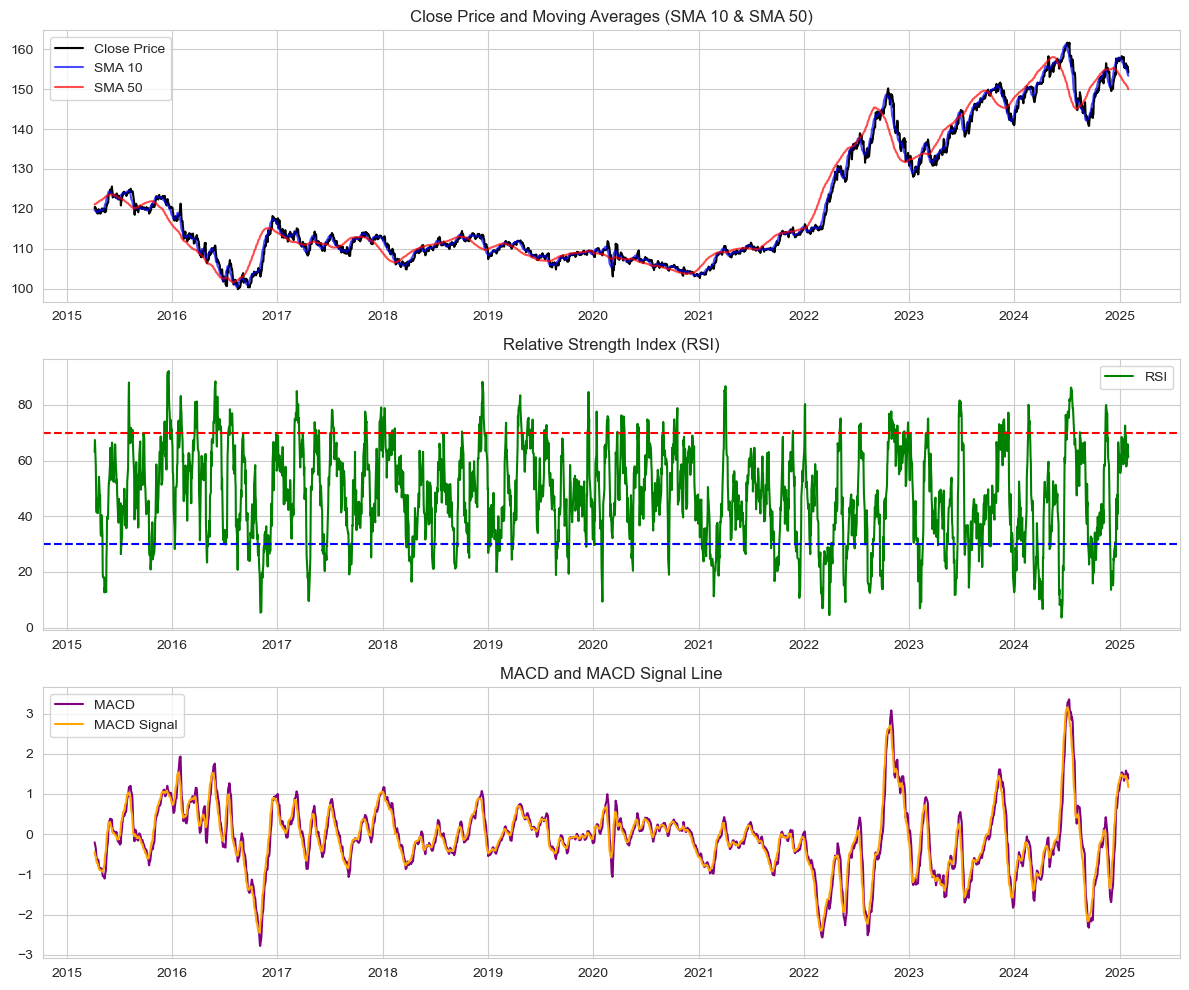

Epoch 1/50


c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13798.8887
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11138.0020
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9818.9072
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8769.2666
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7697.7539
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6553.9912
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5761.7026
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5082.7485
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4388.4795
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3748.9026
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3276.4204
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2672.5166
Epoch 13/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2324.7268
Epoch 14/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1916.6503
Epoch 15/50
128/128 ━━━━

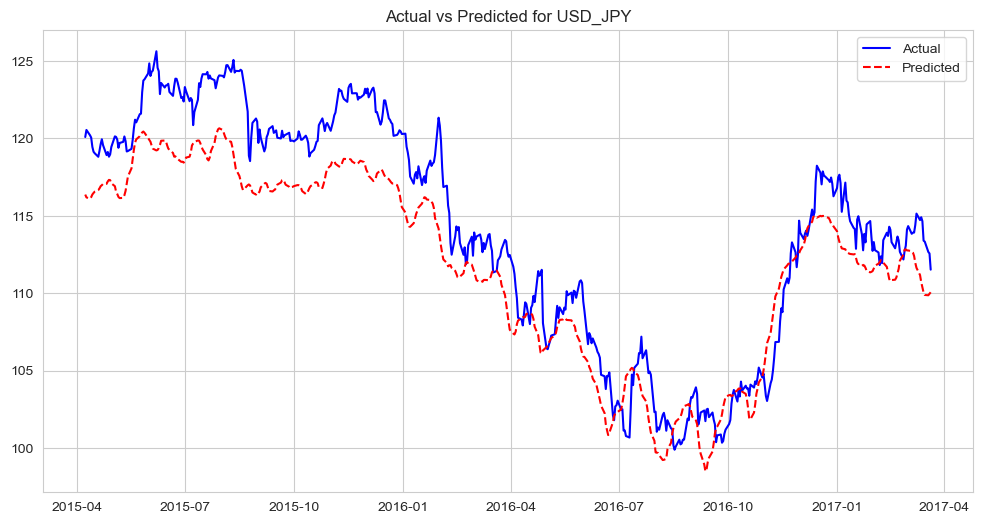

Processing USD_CHF...


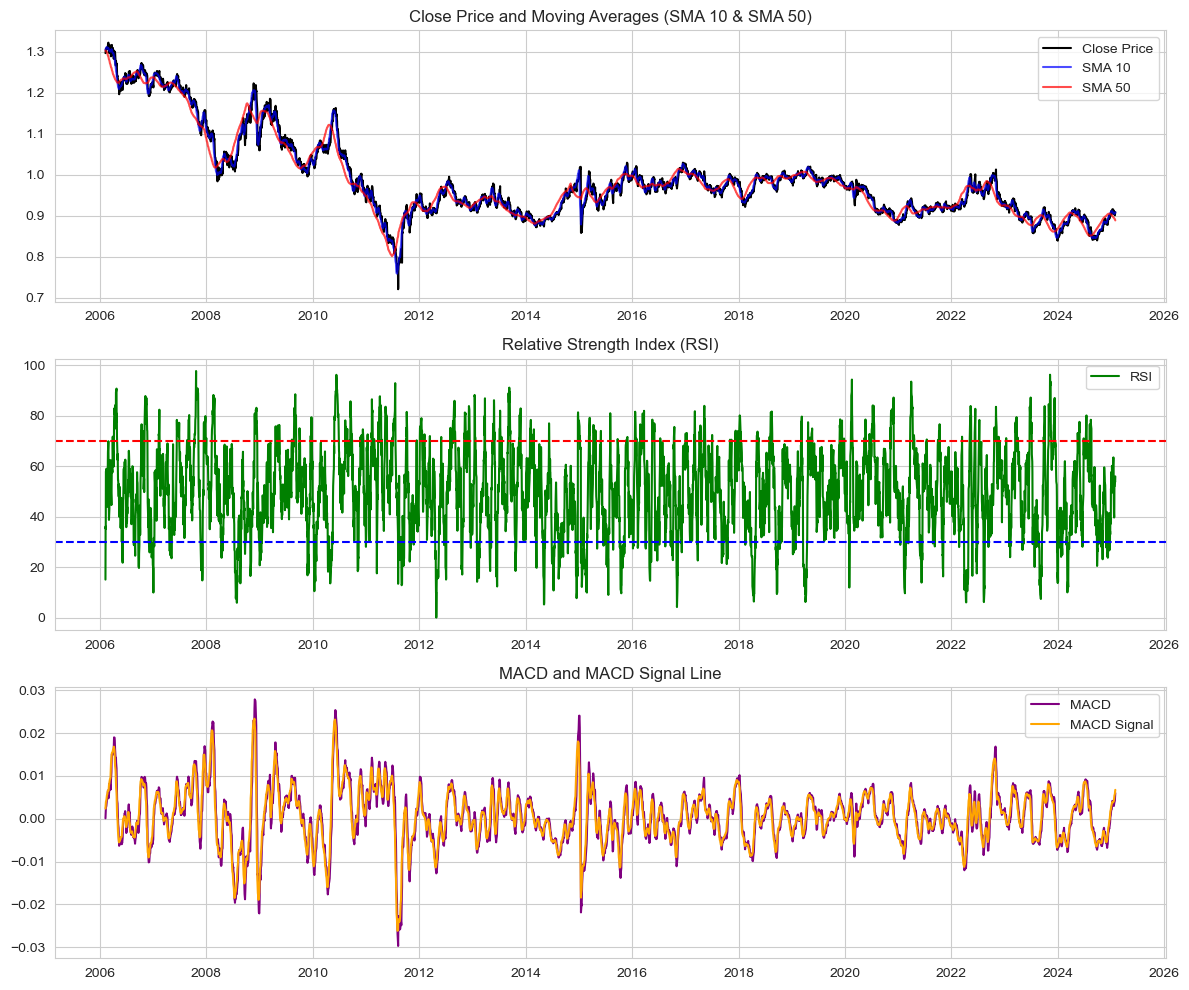

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0695
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.2613e-04
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2285e-04
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.2288e-04
Epoch 5/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.8838e-04
Epoch 6/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.5472e-04
Epoch 7/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4615e-04
Epoch 8/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1751e-04
Epoch 9/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.2051e-04
Epoch 10/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.7988e-04
Epoch 11/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3436e-04
Epoch 12/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.4811e-04
Epoch 13/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0131e-04
Epoch 14/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1487e-04
Epoch

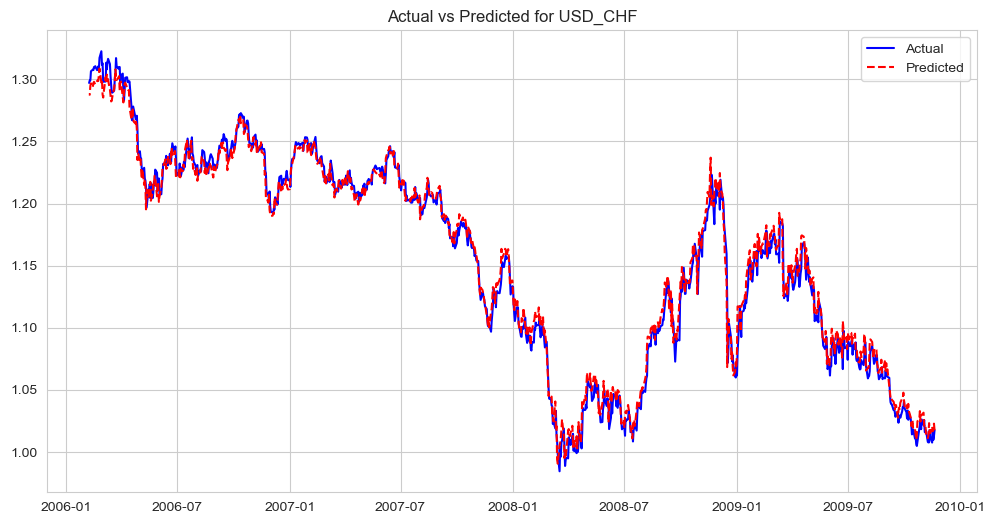

Final RMSE results for all pairs: {'EUR_USD': 0.008504019362491717, 'GBP_USD': 0.00973913483234217, 'USD_JPY': 3.0931153728000864, 'USD_CHF': 0.009556467324965158}


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = data.ewm(span=fast_period, min_periods=1, adjust=False).mean()
    slow_ema = data.ewm(span=slow_period, min_periods=1, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, min_periods=1, adjust=False).mean()
    return macd, signal

# Function to load and preprocess Forex data
def load_and_preprocess(csv_file, add_indicators=True):
    df = pd.read_csv(csv_file)
    
    # Convert all column names to lowercase and remove spaces
    df.columns = df.columns.str.lower().str.strip()
    
    # Handle different date column names
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
    elif 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    else:
        raise ValueError(f"Neither 'date' nor 'timestamp' found in {csv_file}. Available columns: {df.columns}")

    # Ensure required columns exist
    required_cols = {'open', 'high', 'low', 'close'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns in {csv_file}. Required: {required_cols}, Found: {set(df.columns)}")

    # Add Technical Indicators (Optional)
    if add_indicators:
        df['SMA_10'] = df['close'].rolling(window=10).mean()
        df['SMA_50'] = df['close'].rolling(window=50).mean()
        df['RSI'] = calculate_rsi(df['close'])
        df['MACD'], df['MACD_signal'] = calculate_macd(df['close'])

    df.dropna(inplace=True)  # Drop NaNs from indicators

    # Features & Target
    X = df[['open', 'high', 'low', 'SMA_10', 'SMA_50', 'RSI', 'MACD']]
    y = df['close'].shift(-1)  # Predict next day's close price
    X, y = X.iloc[:-1], y.iloc[:-1]  # Align lengths

    # Normalize Data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return df, X_scaled, y.values, scaler

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Plot Technical Indicators and Actual vs Predicted
def plot_results(df, y_test, y_pred, currency_pair):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-len(y_test):], y_test, label="Actual", color="blue")
    plt.plot(df.index[-len(y_pred):], y_pred, label="Predicted", color="red", linestyle="--")
    plt.title(f"Actual vs Predicted for {currency_pair}")
    plt.legend()
    plt.show()

# Function to plot Technical Indicators (SMA, RSI, MACD)
def plot_technical_indicators(df):
    fig, axes = plt.subplots(3, 1, figsize=(12, 10))

    # Close Price and SMAs
    axes[0].plot(df.index, df['close'], label='Close Price', color='black')
    axes[0].plot(df.index, df['SMA_10'], label='SMA 10', color='blue', alpha=0.7)
    axes[0].plot(df.index, df['SMA_50'], label='SMA 50', color='red', alpha=0.7)
    axes[0].set_title('Close Price and Moving Averages (SMA 10 & SMA 50)')
    axes[0].legend()

    # RSI
    axes[1].plot(df.index, df['RSI'], label='RSI', color='green')
    axes[1].axhline(70, color='red', linestyle='--')
    axes[1].axhline(30, color='blue', linestyle='--')
    axes[1].set_title('Relative Strength Index (RSI)')
    axes[1].legend()

    # MACD
    axes[2].plot(df.index, df['MACD'], label='MACD', color='purple')
    axes[2].plot(df.index, df['MACD_signal'], label='MACD Signal', color='orange')
    axes[2].set_title('MACD and MACD Signal Line')
    axes[2].legend()

    plt.tight_layout()
    plt.show()

# Train & Evaluate LSTM Model
def train_and_evaluate_lstm(currency_pairs):
    results = {}

    for pair in currency_pairs:
        csv_file = f"{pair}_10yr.csv"
        print(f"Processing {pair}...")

        try:
            # Load and Preprocess Data
            df, X_scaled, y, scaler = load_and_preprocess(csv_file)

            # Plot Technical Indicators
            plot_technical_indicators(df)

            # Create sequences for LSTM
            time_steps = 10
            X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

            # Train-Test Split
            split = int(len(X_seq) * 0.8)
            X_train, X_test = X_seq[:split], X_seq[split:]
            y_train, y_test = y_seq[:split], y_seq[split:]

            # Build LSTM Model
            model = tf.keras.Sequential([
                tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
                tf.keras.layers.LSTM(50),
                tf.keras.layers.Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')

            # Train Model
            model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1)

            # Predictions
            y_pred = model.predict(X_test)

            # Convert back to original scale
            y_pred = y_pred.flatten()

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))

            print(f"{pair} RMSE: {rmse}\n")
            results[pair] = rmse

            # Plot actual vs predicted values
            plot_results(df, y_test, y_pred, pair)

        except Exception as e:
            print(f"Error processing {pair}: {e}")

    print("Final RMSE results for all pairs:", results)

# Main Execution
currency_pairs = ["EUR_USD", "GBP_USD", "USD_JPY", "USD_CHF"]
train_and_evaluate_lstm(currency_pairs)

Backtesting Strategy

In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Function to calculate RSI (Relative Strength Index)
def calculate_rsi(data, period=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to calculate MACD (Moving Average Convergence Divergence)
def calculate_macd(data, fast_period=12, slow_period=26, signal_period=9):
    fast_ema = data.ewm(span=fast_period, adjust=False).mean()
    slow_ema = data.ewm(span=slow_period, adjust=False).mean()
    macd = fast_ema - slow_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

# Function to load and preprocess forex data
def load_and_preprocess(csv_file, add_indicators=True):
    df = pd.read_csv(csv_file)
    
    # Handle different timestamp column names
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
    elif 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
    else:
        raise KeyError("CSV must contain either 'date' or 'timestamp' column.")
    
    # Add Technical Indicators (Optional)
    if add_indicators:
        df['SMA_10'] = df['close'].rolling(window=10).mean()
        df['SMA_50'] = df['close'].rolling(window=50).mean()
        df['RSI'] = calculate_rsi(df['close'])
        df['MACD'], df['MACD_signal'] = calculate_macd(df['close'])

    df.dropna(inplace=True)  # Drop rows with NaN values

    # Features & Target
    X = df[['open', 'high', 'low', 'SMA_10', 'SMA_50', 'RSI', 'MACD']]
    y = df['close'].shift(-1)  # Predict next day's close price
    X, y = X.iloc[:-1], y.iloc[:-1]  # Align lengths

    # Normalize Data
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    return df, X_scaled, y.values, scaler

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Backtest Strategy: Buy/Sell Based on Predicted Prices
def backtest_strategy(currency_pairs, buy_threshold=0.01, sell_threshold=-0.01, initial_balance=10000):
    portfolio = {}

    for pair in currency_pairs:
        print(f"\n🔍 Backtesting {pair}...")

        try:
            df, X_scaled, y, scaler = load_and_preprocess(f"{pair}_10yr.csv")
        except Exception as e:
            print(f"❌ Error loading {pair}: {e}")
            continue

        time_steps = 10
        X_seq, y_seq = create_sequences(X_scaled, y, time_steps)

        # Train-Test Split
        split = int(len(X_seq) * 0.8)
        X_train, X_test = X_seq[:split], X_seq[split:]
        y_train, y_test = y_seq[:split], y_seq[split:]

        # Ensure we have enough data to train
        if len(X_train) == 0 or len(X_test) == 0:
            print(f"⚠️ Not enough data to train {pair}. Skipping...")
            continue

        # Build and Train LSTM Model
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
            tf.keras.layers.LSTM(50),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

        # Predictions
        y_pred = model.predict(X_test).flatten()

        # Rescale predicted & actual prices
        X_test_reshaped = X_test[:, -1, :-1]  # Last time step inputs
        y_pred_rescaled = scaler.inverse_transform(np.concatenate([X_test_reshaped, y_pred.reshape(-1, 1)], axis=1))[:, -1]
        y_test_rescaled = scaler.inverse_transform(np.concatenate([X_test_reshaped, y_test.reshape(-1, 1)], axis=1))[:, -1]

        # Simulate Trading Strategy
        balance = initial_balance
        position = 0  # No open positions
        equity = []

        for i in range(1, len(y_test_rescaled)):
            actual_price = y_test_rescaled[i]
            predicted_price = y_pred_rescaled[i]

            # Buy Signal
            if predicted_price > actual_price * (1 + buy_threshold) and position == 0:
                position = balance / actual_price  # Buy max units
                print(f"✅ Buy {position:.2f} units at {actual_price:.5f} on {df.index[split + i]}")
                balance = 0

            # Sell Signal
            elif predicted_price < actual_price * (1 + sell_threshold) and position > 0:
                balance = position * actual_price  # Sell all
                print(f"❌ Sell {position:.2f} units at {actual_price:.5f} on {df.index[split + i]}")
                position = 0

            # Track Portfolio Value
            equity.append(balance + position * actual_price)

        final_balance = balance + position * y_test_rescaled[-1]  # Final balance if holding
        print(f"📊 Final Balance for {pair}: ${final_balance:.2f}")
        portfolio[pair] = final_balance

    print("\n📌 Portfolio Summary:")
    for pair, final_balance in portfolio.items():
        print(f"💰 {pair}: ${final_balance:.2f}")

# Run Backtesting
currency_pairs = ["EUR_USD", "GBP_USD", "USD_JPY", "USD_CHF"]
backtest_strategy(currency_pairs)


🔍 Backtesting EUR_USD...


c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
✅ Buy 696256.25 units at 0.01436 on 2017-04-02 00:00:00
❌ Sell 696256.25 units at 0.01530 on 2017-01-18 00:00:00
✅ Buy 709799.89 units at 0.01500 on 2017-01-16 00:00:00
❌ Sell 709799.89 units at 0.01344 on 2016-06-19 00:00:00
✅ Buy 714708.23 units at 0.01334 on 2016-06-12 00:00:00
❌ Sell 714708.23 units at 0.01342 on 2016-04-11 00:00:00
✅ Buy 717576.25 units at 0.01337 on 2016-04-07 00:00:00
❌ Sell 717576.25 units at 0.01354 on 2016-03-30 00:00:00
✅ Buy 724948.35 units at 0.01340 on 2016-03-28 00:00:00
❌ Sell 724948.35 units at 0.01383 on 2016-03-24 00:00:00
✅ Buy 716789.17 units at 0.01399 on 2016-03-14 00:00:00
❌ Sell 716789.17 units at 0.01399 on 2016-02-17 00:00:00
✅ Buy 709037.16 units at 0.01415 on 2016-02-07 00:00:00
❌ Sell 709037.16 units at 0.01478 on 2015-12-17 00:00:00
✅ Buy 710510.94 units at 0.01475 on 2015-12-10 00:00:00
❌ Sell 710510.94 units at 0.01324 on 2015-09-06 00:00:00
✅ Buy 700925.53 units at 0.01342 on 2015-08-30 00:00:00


c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
✅ Buy 1195394.95 units at 0.00837 on 2017-03-21 00:00:00
❌ Sell 1195394.95 units at 0.00777 on 2017-02-14 00:00:00
✅ Buy 1228332.19 units at 0.00757 on 2017-02-12 00:00:00
❌ Sell 1228332.19 units at 0.00803 on 2017-02-06 00:00:00
✅ Buy 1228914.24 units at 0.00803 on 2017-02-01 00:00:00
❌ Sell 1228914.24 units at 0.00883 on 2017-01-31 00:00:00
✅ Buy 1287948.32 units at 0.00843 on 2017-01-26 00:00:00
❌ Sell 1287948.32 units at 0.00758 on 2016-12-18 00:00:00
✅ Buy 1238691.55 units at 0.00788 on 2016-12-11 00:00:00
❌ Sell 1238691.55 units at 0.00817 on 2016-12-05 00:00:00
✅ Buy 1280003.39 units at 0.00791 on 2016-12-01 00:00:00
❌ Sell 1280003.39 units at 0.00796 on 2016-11-24 00:00:00
✅ Buy 1305289.65 units at 0.00781 on 2016-11-21 00:00:00
❌ Sell 1305289.65 units at 0.00822 on 2016-11-17 00:00:00
✅ Buy 1280827.00 units at 0.00837 on 2016-11-10 00:00:00
❌ Sell 1280827.00 units at 0.00841 on 2016-11-01 00:00:00
✅ Buy 1281459.18 units at 0.00841 on 201

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
✅ Buy 14.59 units at 685.37154 on 2017-03-13 00:00:00
❌ Sell 14.59 units at 692.22313 on 2017-03-05 00:00:00
✅ Buy 14.49 units at 696.94625 on 2016-12-25 00:00:00
❌ Sell 14.49 units at 636.09163 on 2016-11-09 00:00:00
✅ Buy 14.65 units at 629.12350 on 2016-10-24 00:00:00
❌ Sell 14.65 units at 621.93454 on 2016-10-04 00:00:00
✅ Buy 14.66 units at 621.70759 on 2016-09-13 00:00:00
❌ Sell 14.66 units at 621.70145 on 2016-08-28 00:00:00
✅ Buy 14.34 units at 635.61318 on 2016-07-28 00:00:00
❌ Sell 14.34 units at 640.64300 on 2016-07-10 00:00:00
✅ Buy 14.06 units at 653.05805 on 2016-05-19 00:00:00
❌ Sell 14.06 units at 681.27408 on 2016-05-12 00:00:00
✅ Buy 14.52 units at 659.78696 on 2016-05-02 00:00:00
❌ Sell 14.52 units at 674.26915 on 2016-04-20 00:00:00
✅ Buy 12.97 units at 755.22462 on 2015-08-12 00:00:00
❌ Sell 12.97 units at 758.24250 on 2015-08-06 00:00:00
✅ Buy 13.31 units at 738.57716 on 2015-07-23 00:00:00
❌ Sell 13.31 units at 752.05338 on

c:\Users\acer\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✅ Buy 316271.38 units at 0.03162 on 2009-08-21 00:00:00
❌ Sell 316271.38 units at 0.03140 on 2009-08-20 00:00:00
✅ Buy 313114.87 units at 0.03172 on 2009-07-08 00:00:00
❌ Sell 313114.87 units at 0.03285 on 2009-07-07 00:00:00
✅ Buy 323018.54 units at 0.03184 on 2009-06-19 00:00:00
❌ Sell 323018.54 units at 0.03197 on 2009-06-18 00:00:00
✅ Buy 304749.40 units at 0.03389 on 2009-05-29 00:00:00
❌ Sell 304749.40 units at 0.03406 on 2009-05-28 00:00:00
✅ Buy 289440.53 units at 0.03586 on 2009-05-11 00:00:00
❌ Sell 289440.53 units at 0.03658 on 2009-05-08 00:00:00
✅ Buy 291319.78 units at 0.03634 on 2009-05-01 00:00:00
❌ Sell 291319.78 units at 0.03614 on 2009-04-30 00:00:00
✅ Buy 287339.00 units at 0.03664 on 2009-03-26 00:00:00
❌ Sell 287339.00 units at 0.03709 on 2009-03-25 00:00:00
✅ Buy 320960.14 units at 0.03320 on 2009-01-23 00:00:00
❌ Sell 320960.14 units at 0.03371 on 2009-01-22 00:00:00
✅ Buy 333012.20 units at 0.03249 on 2009-01-19 00:00:00


Market Regime Detection

Model is not converging.  Current: 10183.334232842008 is not greater than 10186.636644388285. Delta is -3.3024115462776535
Model is not converging.  Current: 10230.637210030392 is not greater than 10234.093017693773. Delta is -3.4558076633802557


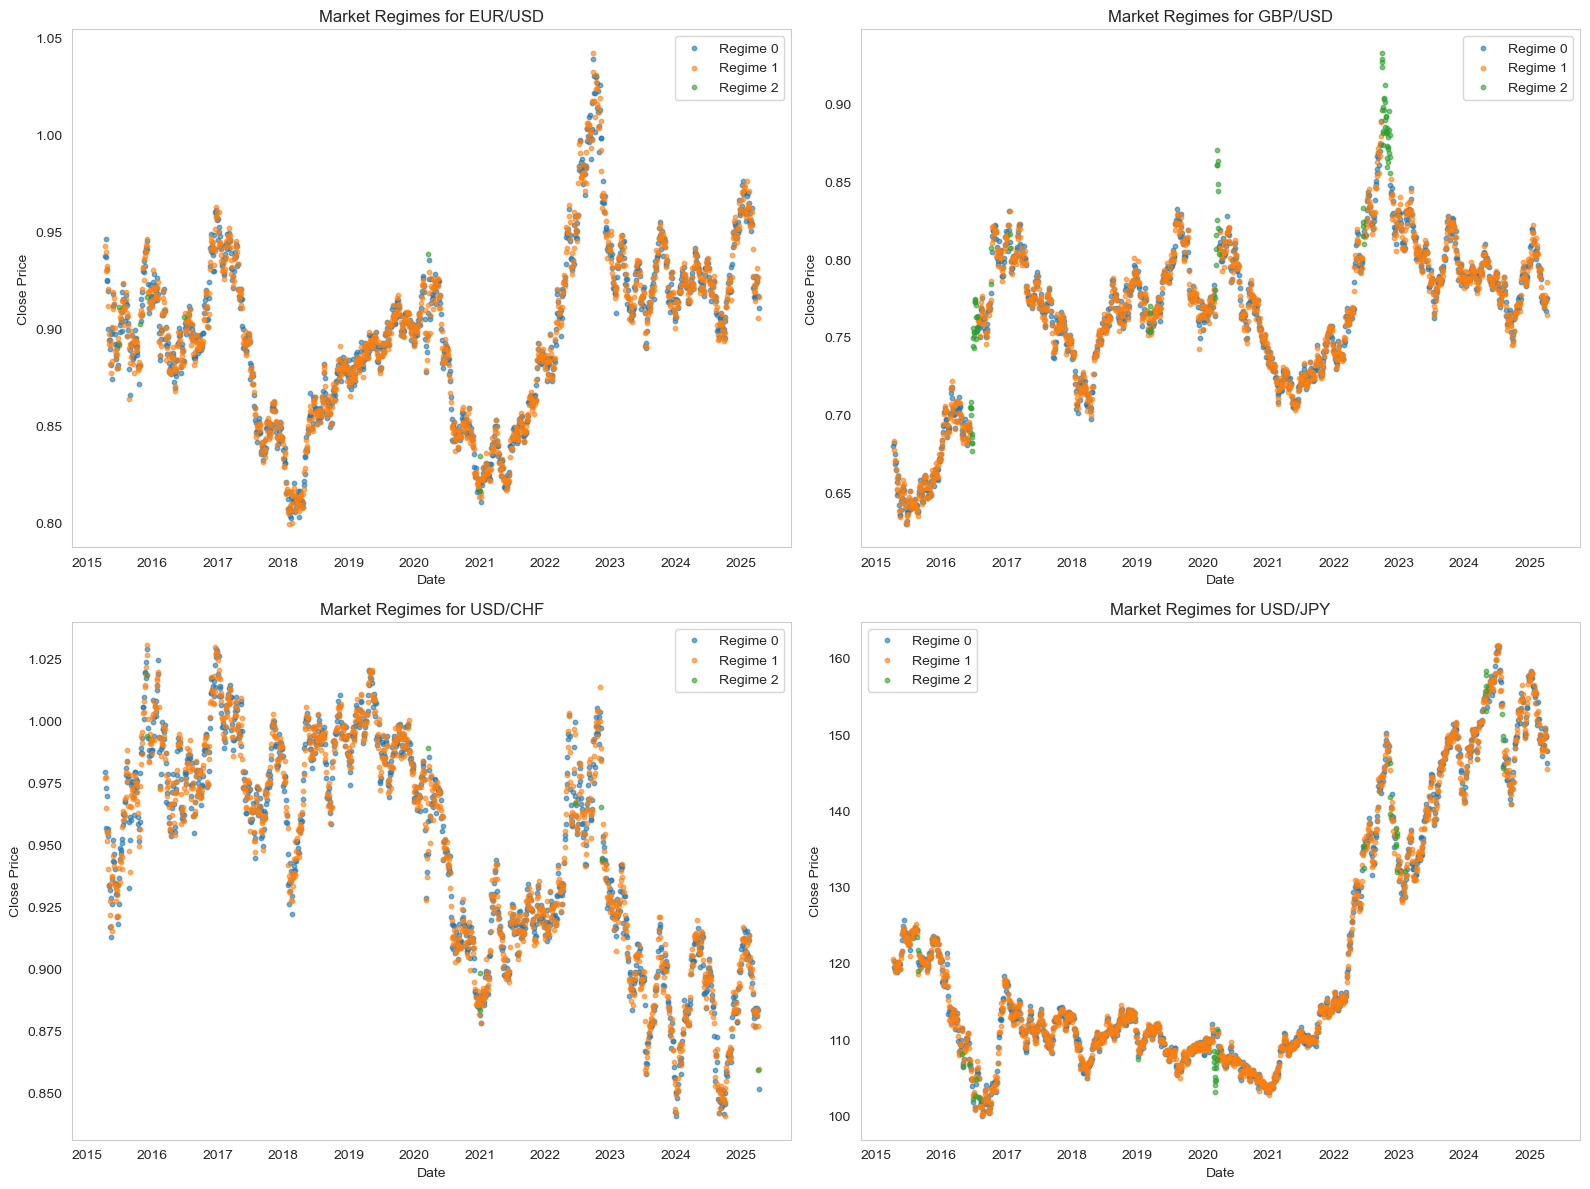

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import seaborn as sns

# File paths (Modify these paths as needed)
file_paths = {
    "EUR/USD": "EUR_USD_Yahoo.csv",
    "GBP/USD": "GBP_USD_Yahoo.csv",
    "USD/CHF": "USD_CHF_Yahoo.csv",
    "USD/JPY": "USD_JPY_Yahoo.csv",
}

# Load and preprocess data
def load_data(file_path):
    df = pd.read_csv(file_path)
    
    # Handle different date column names
    if 'date' in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce", utc=True)
        df.set_index("date", inplace=True)
    elif 'timestamp' in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce", utc=True)
        df.set_index("timestamp", inplace=True)
    else:
        raise KeyError("CSV must contain either 'date' or 'timestamp' column.")
    
    # Drop NaT values in index
    df = df[~df.index.isna()]
    
    # Keep only Close price
    df = df[["close"]]
    df.columns = ["Close"]
    
    # Calculate log returns
    df["Log_Returns"] = np.log(df["Close"] / df["Close"].shift(1))
    
    return df.dropna()

# Load all datasets
market_data = {pair: load_data(path) for pair, path in file_paths.items()}

# Fit HMM to detect market regimes
def detect_market_regimes(df, n_states=3):
    model = GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=1000, random_state=42)
    
    # Train the model on log returns
    model.fit(df[["Log_Returns"]])
    
    # Predict market regimes
    df["Regime"] = model.predict(df[["Log_Returns"]])
    
    return df, model

# Apply HMM to all currency pairs
regime_results = {}
for pair, df in market_data.items():
    regime_results[pair], _ = detect_market_regimes(df)

# Plot all four market regimes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

# Dynamically generate colors
n_states = 3
colors = sns.color_palette("tab10", n_states)

for idx, (pair, df) in enumerate(regime_results.items()):
    axes[idx].set_title(f"Market Regimes for {pair}")
    
    # Convert timezone-aware datetime index to naive datetime (fix for matplotlib)
    df = df.copy()
    df.index = df.index.tz_localize(None)
    
    for regime in range(n_states):
        axes[idx].scatter(
            df.index[df["Regime"] == regime],
            df["Close"][df["Regime"] == regime],
            color=colors[regime],
            label=f"Regime {regime}",
            alpha=0.6,
            s=10
        )
    
    axes[idx].set_xlabel("Date")
    axes[idx].set_ylabel("Close Price")
    axes[idx].legend()
    axes[idx].grid()

plt.tight_layout()
plt.show()

Regime 0 in all pairs seems to capture periods of high volatility and potential market crashes.

Regime 1 (when present) often represents a bearish or riskier phase.

Regime 2 (or 0 in USD/JPY and USD/CHF) mostly captures stable growth.

Trade Position Sizing

In [13]:
import vectorbt as vbt
import pandas as pd
import numpy as np
import pandas_ta as ta

# ✅ Load Data
pairs = ["EUR_USD", "GBP_USD", "USD_CHF", "USD_JPY"]
data = {}

for pair in pairs:
    df = pd.read_csv(f"{pair}_10yr.csv", parse_dates=["timestamp"])
    df.set_index("timestamp", inplace=True)
    data[pair] = df

# ✅ Backtest Function
def backtest(pair, risk_per_trade=0.02, atr_multiplier=1.5, init_cash=10000):
    df = data[pair].copy()

    # ✅ Calculate Indicators
    df["ATR"] = ta.atr(df["high"], df["low"], df["close"], length=14)
    df["EMA_20"] = df["close"].ewm(span=20, adjust=False).mean()
    df["EMA_50"] = df["close"].ewm(span=50, adjust=False).mean()
    df["RSI"] = ta.rsi(df["close"], length=14)
    df["ADX"] = ta.adx(df["high"], df["low"], df["close"], length=14)["ADX_14"]

    # ✅ Dynamic Position Sizing (Risk 1-3%)
    df["Risk_Per_Trade"] = np.where(df["ADX"] > 30, 0.03 * init_cash, 0.01 * init_cash)
    df["Position_Size"] = df["Risk_Per_Trade"] / (df["ATR"] * atr_multiplier)
    df["Position_Size"] = df["Position_Size"].clip(0, 0.1 * init_cash)  # Limit size

    # ✅ Entry & Exit Conditions
    df["Buy"] = (df["EMA_20"] > df["EMA_50"]) & (df["RSI"] > 55) & (df["ADX"] > 20)
    df["Trailing_Stop"] = df["close"].rolling(5).max() - (df["ATR"] * atr_multiplier)
    df["Sell"] = df["close"] < df["Trailing_Stop"]

    # ✅ Run Vectorbt Portfolio
    pf = vbt.Portfolio.from_signals(
        close=df["close"],
        entries=df["Buy"],
        exits=df["Sell"],
        size=df["Position_Size"],
        fees=0.0005,
        init_cash=init_cash,
        freq="1D"
    )

    return df, pf

# ✅ Run Backtest for All Pairs
results = {}
for pair in pairs:
    df, pf = backtest(pair)
    results[pair] = pf

    # ✅ Print Performance Stats
    print(f"\n🔹 Performance for {pair}:")
    print(pf.stats())

    # ✅ Plot Equity Curve
    pf.plot(title=f"Equity Curve - {pair}").show()


🔹 Performance for EUR_USD:
Start                         2025-04-09 00:00:00
End                           2015-04-08 00:00:00
Period                         2608 days 00:00:00
Start Value                               10000.0
End Value                             9953.850265
Total Return [%]                        -0.461497
Benchmark Return [%]                   -16.126436
Max Gross Exposure [%]                  10.382124
Total Fees Paid                         31.409735
Max Drawdown [%]                         0.961879
Max Drawdown Duration          1974 days 00:00:00
Total Trades                                   35
Total Closed Trades                            34
Total Open Trades                               1
Open Trade PnL                           -3.55524
Win Rate [%]                            26.470588
Best Trade [%]                           5.222253
Worst Trade [%]                         -1.823836
Avg Winning Trade [%]                    1.751868
Avg Losing Trade [%]  


🔹 Performance for GBP_USD:
Start                         2025-04-09 00:00:00
End                           2015-04-08 00:00:00
Period                         2608 days 00:00:00
Start Value                               10000.0
End Value                             9879.223775
Total Return [%]                        -1.207762
Benchmark Return [%]                   -47.627432
Max Gross Exposure [%]                   9.297512
Total Fees Paid                         33.256225
Max Drawdown [%]                         1.530915
Max Drawdown Duration          1947 days 00:00:00
Total Trades                                   43
Total Closed Trades                            42
Total Open Trades                               1
Open Trade PnL                            1.17462
Win Rate [%]                            35.714286
Best Trade [%]                           5.661772
Worst Trade [%]                         -2.970422
Avg Winning Trade [%]                    1.163848
Avg Losing Trade [%]  


🔹 Performance for USD_CHF:
Start                         2025-04-09 00:00:00
End                           2006-02-07 00:00:00
Period                         5000 days 00:00:00
Start Value                               10000.0
End Value                              9981.11477
Total Return [%]                        -0.188852
Benchmark Return [%]                    53.612032
Max Gross Exposure [%]                  13.217257
Total Fees Paid                          67.76523
Max Drawdown [%]                         3.860623
Max Drawdown Duration          4365 days 00:00:00
Total Trades                                   69
Total Closed Trades                            68
Total Open Trades                               1
Open Trade PnL                            -6.3514
Win Rate [%]                            47.058824
Best Trade [%]                           11.17794
Worst Trade [%]                         -7.115929
Avg Winning Trade [%]                    2.049699
Avg Losing Trade [%]  


🔹 Performance for USD_JPY:
Start                               2025-04-09 00:00:00
End                                 2015-04-08 00:00:00
Period                               2607 days 00:00:00
Start Value                                     10000.0
End Value                                   8165.532072
Total Return [%]                             -18.344679
Benchmark Return [%]                         -17.367467
Max Gross Exposure [%]                            100.0
Total Fees Paid                              299.678203
Max Drawdown [%]                              20.784937
Max Drawdown Duration                2540 days 00:00:00
Total Trades                                         37
Total Closed Trades                                  37
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  21.621622
Best Trade [%]                                 7.007661
Worst Trade [%]     

Predicting Tommorow's Price


🔄 Training Model for EUR_USD (up to 2025-04-09)...
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.0175
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0019
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0016
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0014
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0013
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0013
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0012
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0011
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 8.8242e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.2737e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.8431e-04
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.1710e-04
Epoch 13/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 7.1401e-04
Epoch 14/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.7495

💾 Model Saved: C:/Users/acer/Desktop/QF Project/models/EUR_USD_lstm_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📊 Precision: 0.5440, Recall: 0.5037

🔄 Training Model for GBP_USD (up to 2025-04-09)...
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0121
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 6.4784e-04
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.4397e-04
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 4.5668e-04
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 3.8315e-04
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.7787e-04
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.3463e-04
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.7587e-04
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 2.8693e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.3924e-04
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 2.8438e-04
Epoch 12/50
72/72 ━━━━━━━━━━━

💾 Model Saved: C:/Users/acer/Desktop/QF Project/models/GBP_USD_lstm_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
📊 Precision: 0.4513, Recall: 0.4322

🔄 Training Model for USD_CHF (up to 2025-04-09)...
Epoch 1/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.0243
Epoch 2/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0021
Epoch 3/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0017
Epoch 4/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0014
Epoch 5/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0011
Epoch 6/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.0011
Epoch 7/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 7.9506e-04
Epoch 8/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 7.3247e-04
Epoch 9/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.1298e-04
Epoch 10/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.1705e-04
Epoch 11/50
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 6.0890e-04
Epoch 12/50
140/140 ━━━━━━━

💾 Model Saved: C:/Users/acer/Desktop/QF Project/models/USD_CHF_lstm_model.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
📊 Precision: 0.4862, Recall: 0.4881

🔄 Training Model for USD_JPY (up to 2025-04-09)...
Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0244
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0020
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0015
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0016
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0011
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0012
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0010
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0011
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 9.7520e-04
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0012
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0010
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 7.9

💾 Model Saved: C:/Users/acer/Desktop/QF Project/models/USD_JPY_lstm_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
📊 Precision: 0.5571, Recall: 0.5693

📅 **Forex Price Predictions (2025-04-10 to 2025-04-19)**
EUR_USD:
  2025-04-10: 1.09998
  2025-04-11: 1.09333
  2025-04-12: 1.08059
  2025-04-13: 1.06821
  2025-04-14: 1.05858
  2025-04-15: 1.05218
  2025-04-16: 1.04856
  2025-04-17: 1.04690
  2025-04-18: 1.04638
  2025-04-19: 1.04637
GBP_USD:
  2025-04-10: 1.23493
  2025-04-11: 1.25675
  2025-04-12: 1.22918
  2025-04-13: 1.18078
  2025-04-14: 1.12633
  2025-04-15: 1.07560
  2025-04-16: 1.03397
  2025-04-17: 1.00322
  2025-04-18: 0.98276
  2025-04-19: 0.97072
USD_CHF:
  2025-04-10: 0.84607
  2025-04-11: 0.84617
  2025-04-12: 0.84714
  2025-04-13: 0.84824
  2025-04-14: 0.84924
  2025-04-15: 0.85006
  2025-04-16: 0.85068
  2025-04-17: 0.85112
  2025-04-18: 0.85141
  2025-04-19: 0.85159
USD_JPY:
  2025-04-10: 145.86504
  2025-04-11: 145.80901
  2025-04-12: 145.84941
  2025-04-13: 145.91496

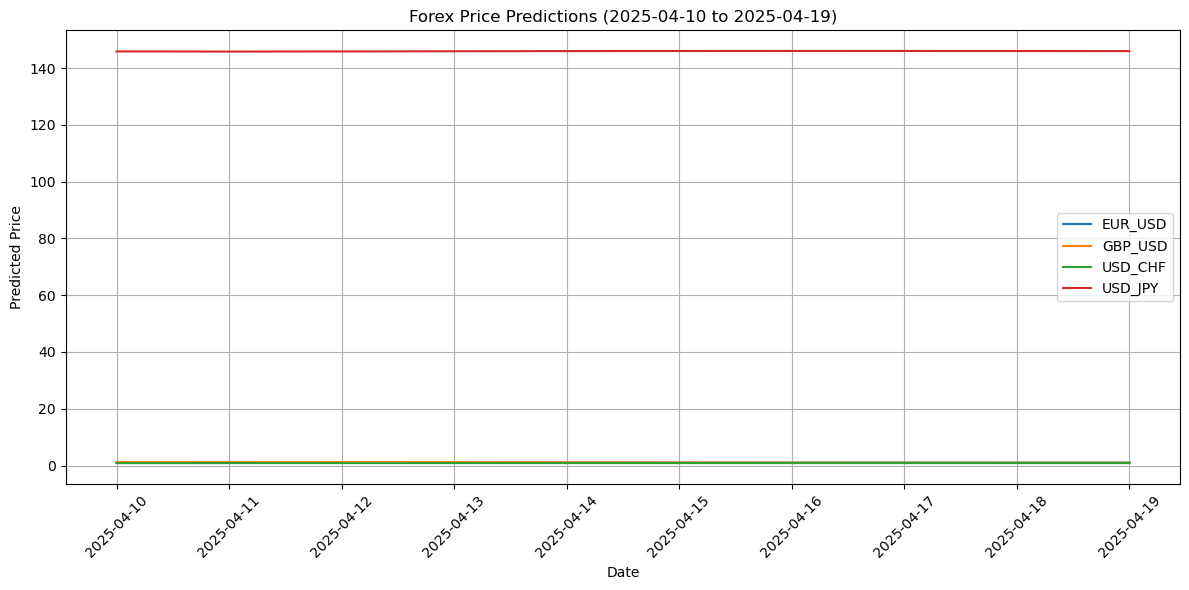

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score
import os

# ✅ Define Forex Pairs
pairs = ["EUR_USD", "GBP_USD", "USD_CHF", "USD_JPY"]
data_path = "C:/Users/acer/Desktop/QF Project/"
model_save_path = "C:/Users/acer/Desktop/QF Project/models/"

# ✅ Create directory if it doesn't exist
os.makedirs(model_save_path, exist_ok=True)

# ✅ Store Results
results = {}
predictions_2025 = {}

# ✅ Loop Over Each Pair
for pair in pairs:
    print(f"\n🔄 Training Model for {pair} (up to 2025-04-09)...")

    # 🔹 Load Data
    file_path = os.path.join(data_path, f"{pair}_10yr.csv")
    if not os.path.exists(file_path):
        print(f"❌ File not found: {file_path}")
        continue

    df = pd.read_csv(file_path)
    df.columns = df.columns.str.strip().str.lower()

    if "timestamp" not in df.columns:
        print(f"❌ 'timestamp' column missing in {pair}_10yr.csv!")
        continue  

    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_localize(None)
    df.set_index("timestamp", inplace=True)
    df.sort_index(inplace=True)

    # ✅ Filter Data: Train on data till 2025-04-09
    df_train = df[df.index <= "2025-04-09"]

    # ✅ Scale 'close' prices
    close_prices = df_train["close"].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    close_scaled = scaler.fit_transform(close_prices)

    # ✅ Prepare Data
    lookback = 50
    X, y = [], []
    for i in range(len(close_scaled) - lookback - 1):
        X.append(close_scaled[i:i+lookback, 0])
        y.append(close_scaled[i+lookback, 0])

    X, y = np.array(X), np.array(y)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    split = int(0.9 * len(X))
    X_train, X_val = X[:split], X[split:]
    y_train, y_val = y[:split], y[split:]

    # ✅ Build & Train Model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(lookback, 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1)

    # ✅ Save Model
    model_path = os.path.join(model_save_path, f"{pair}_lstm_model.h5")
    model.save(model_path)
    print(f"💾 Model Saved: {model_path}")

    # ✅ Predict Validation Set (for metrics)
    y_val_pred = model.predict(X_val).flatten()
    y_val_true = y_val

    # Inverse Transform
    y_val_pred_orig = scaler.inverse_transform(y_val_pred.reshape(-1, 1)).flatten()
    y_val_true_orig = scaler.inverse_transform(y_val_true.reshape(-1, 1)).flatten()

    # ✅ Precision & Recall (based on direction)
    actual_direction = (np.diff(y_val_true_orig) > 0).astype(int)
    predicted_direction = (np.diff(y_val_pred_orig) > 0).astype(int)

    precision = precision_score(actual_direction, predicted_direction, zero_division=0)
    recall = recall_score(actual_direction, predicted_direction, zero_division=0)
    print(f"📊 Precision: {precision:.4f}, Recall: {recall:.4f}")

    # ✅ Predict for Next 10 Days from 2025-04-10
    future_predictions = []
    last_lookback_data = close_scaled[-lookback:].reshape(1, lookback, 1)
    future_dates = pd.date_range(start="2025-04-10", periods=10, freq='D')

    for _ in range(10):
        next_pred = model.predict(last_lookback_data, verbose=0)
        future_predictions.append(next_pred[0, 0])
        last_lookback_data = np.append(last_lookback_data[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    predictions_2025[pair] = dict(zip(future_dates.strftime('%Y-%m-%d'), future_predictions.flatten()))

# ✅ Print Preview of 2025 Predictions
print("\n📅 **Forex Price Predictions (2025-04-10 to 2025-04-19)**")
for pair, future_values in predictions_2025.items():
    print(f"{pair}:")
    for date, price in future_values.items():
        print(f"  {date}: {price:.5f}")

# ✅ Plot Predictions
plt.figure(figsize=(12, 6))
for pair, future_values in predictions_2025.items():
    plt.plot(future_dates, list(future_values.values()), label=pair)

plt.xlabel("Date")
plt.ylabel("Predicted Price")
plt.title("Forex Price Predictions (2025-04-10 to 2025-04-19)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
